In [1]:
%%capture
!pip install chromadb
!pip install datasets
!pip install pyarrow
!pip install open-clip-torch
!pip install sentence-transformers
!pip install langchain_core langchain_openai

In [2]:
import IPython
from IPython.display import HTML, display, Image, Markdown, Video, Audio
from typing import Optional, Sequence, List, Dict, Union

import soundfile as sf

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

from google.colab import userdata

from sentence_transformers import SentenceTransformer
from transformers import ClapModel, ClapProcessor
from datasets import load_dataset

import chromadb
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
from chromadb.utils.data_loaders import ImageLoader
from chromadb.api.types import Document, Embedding, EmbeddingFunction, URI, DataLoader

import numpy as np
import torchaudio
import base64
import torch
import json
import cv2
import os

In [4]:
def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [5]:
path = "mm_vdb"
client = chromadb.PersistentClient(path=path)

In [6]:
ds = load_dataset("KoalaAI/StockImages-CC0")

README.md:   0%|          | 0.00/2.79k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/422M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/467M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3999 [00:00<?, ? examples/s]

In [7]:
indices_to_remove = {586, 1002}

all_indices = set(range(len(ds['train'])))
indices_to_keep = list(all_indices - indices_to_remove)
# Select the remaining entries in the dataset
ds['train'] = ds['train'].select(indices_to_keep)

print(ds['train'])

Dataset({
    features: ['image', 'tags'],
    num_rows: 3997
})


In [8]:
output_folder = "StockImages-cc0"
os.makedirs(output_folder, exist_ok=True)

def process_and_save_image(idx, item):
    try:
        # Since the image is already a PIL image, just save it directly
        image = item['image']
        image.save(os.path.join(output_folder, f"image_{idx}.jpg"))
    except Exception:
        pass

def process_images(dataset):
    for idx, item in enumerate(dataset['train']):
        process_and_save_image(idx, item)

process_images(ds)

In [9]:
image_loader = ImageLoader()
CLIP = OpenCLIPEmbeddingFunction()
image_collection = client.get_or_create_collection(name="image_collection",
                                                   embedding_function = CLIP,
                                                   data_loader = image_loader)

open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [11]:
import torch
import os

ids = []
uris = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running on: {device}")

dataset_folder = "StockImages-cc0"

for i, filename in enumerate(sorted(os.listdir(dataset_folder))):
    if filename.endswith('.jpg'):
        file_path = os.path.join(dataset_folder, filename)
        
        ids.append(str(i))
        uris.append(file_path)

image_collection.add(
    ids=ids,
    uris=uris
)

print(f"Images added to the database using {device}.")

Running on: cuda
Images added to the database using cuda.


Enter your search query -->  catt
Enter the maximum distance (leave blank for no filter):  
Enable debug mode? (yes/no):  


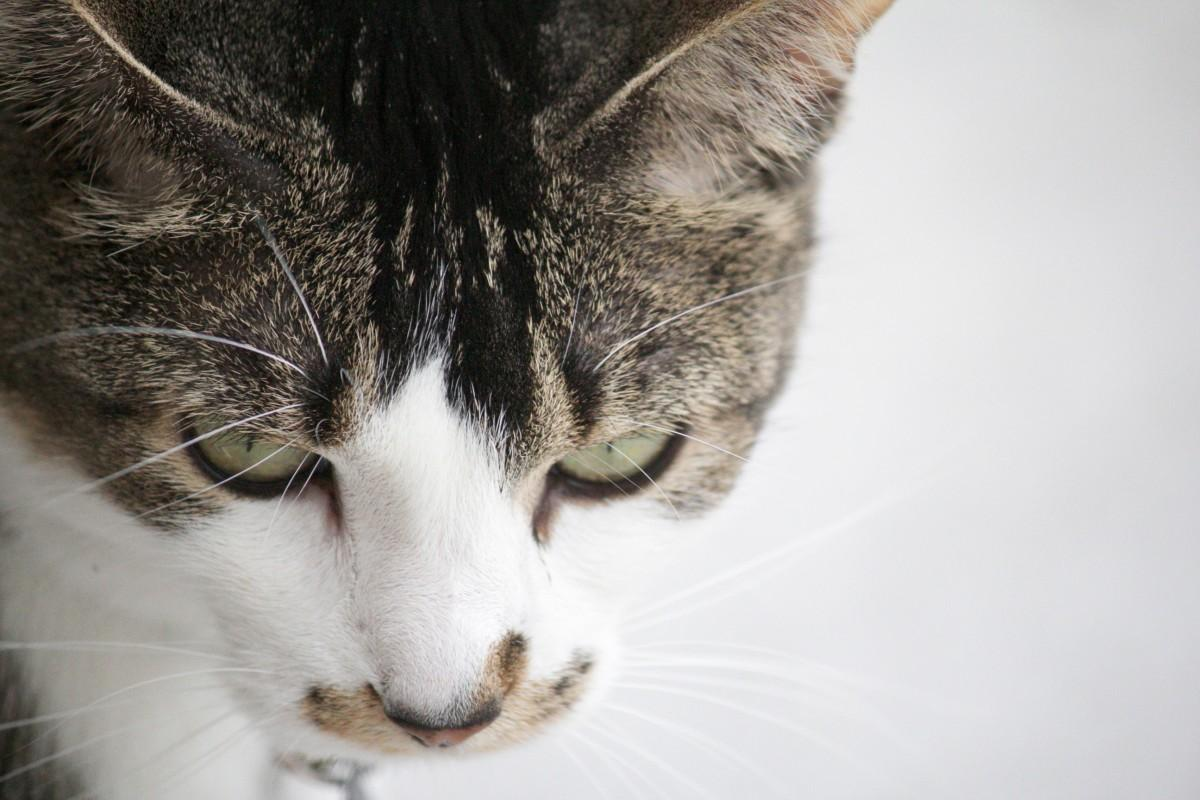

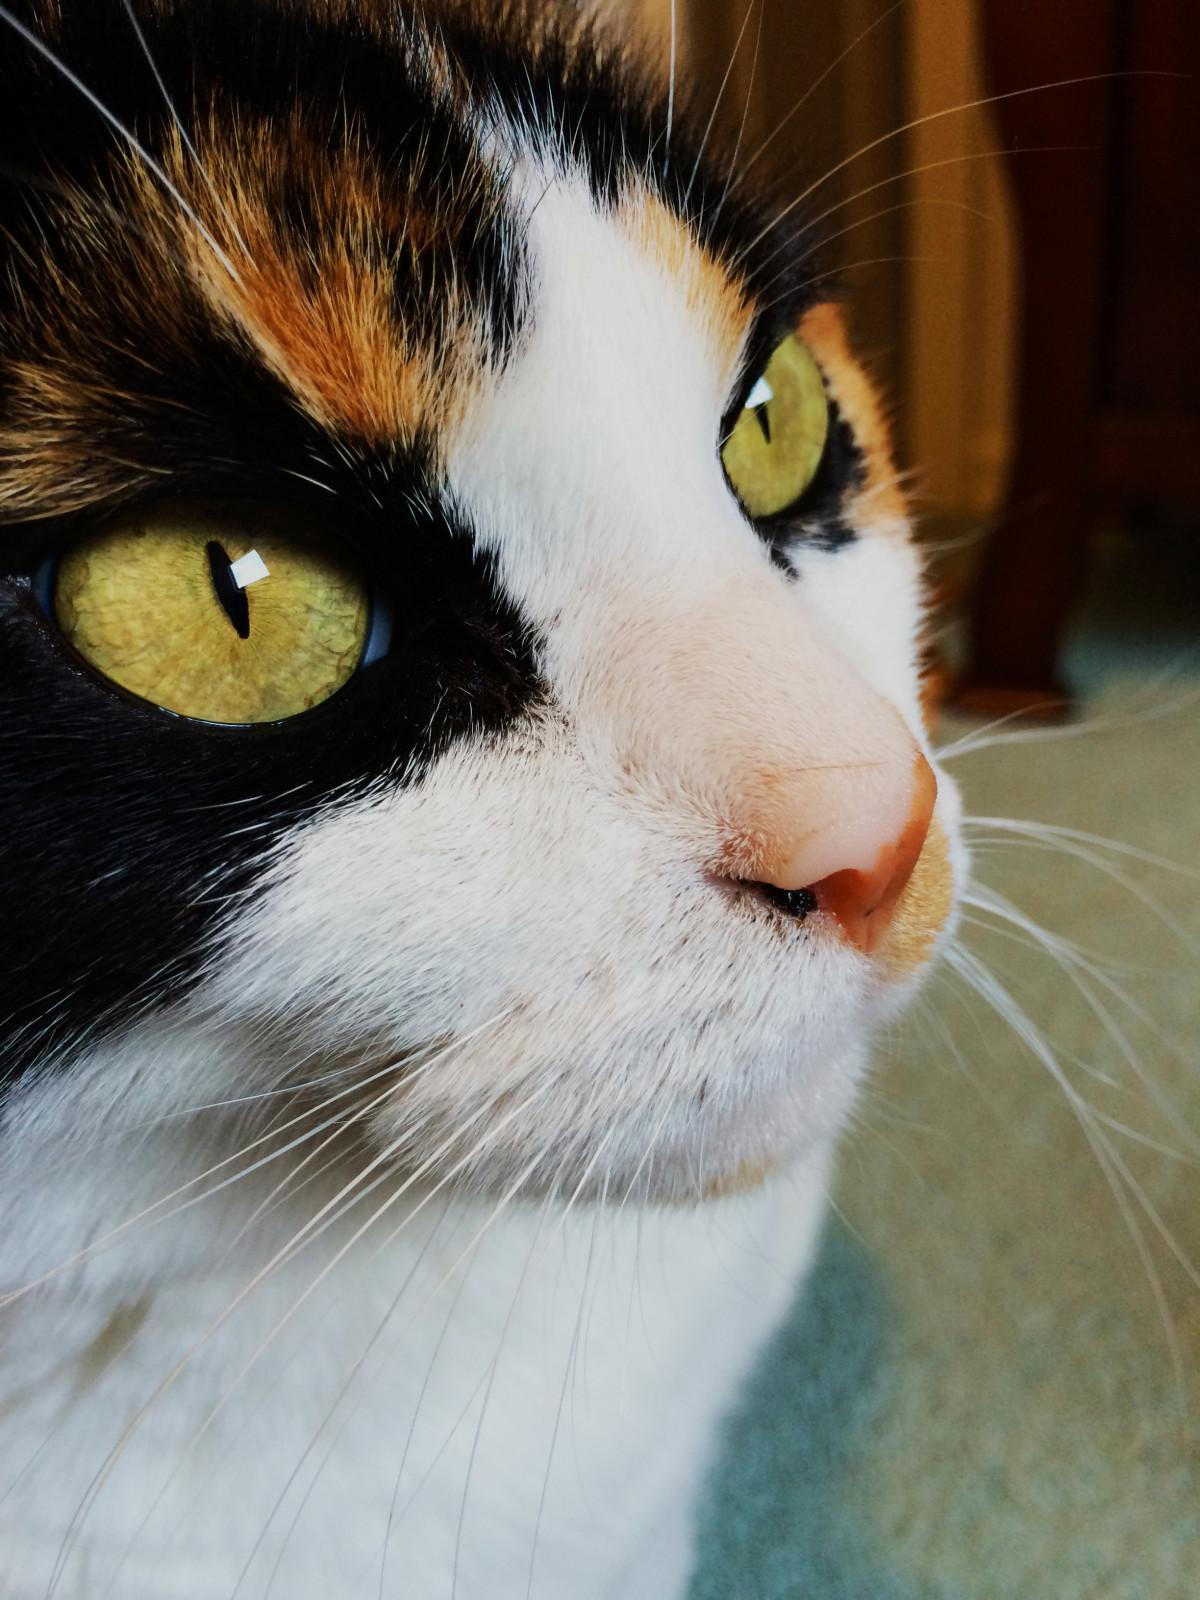

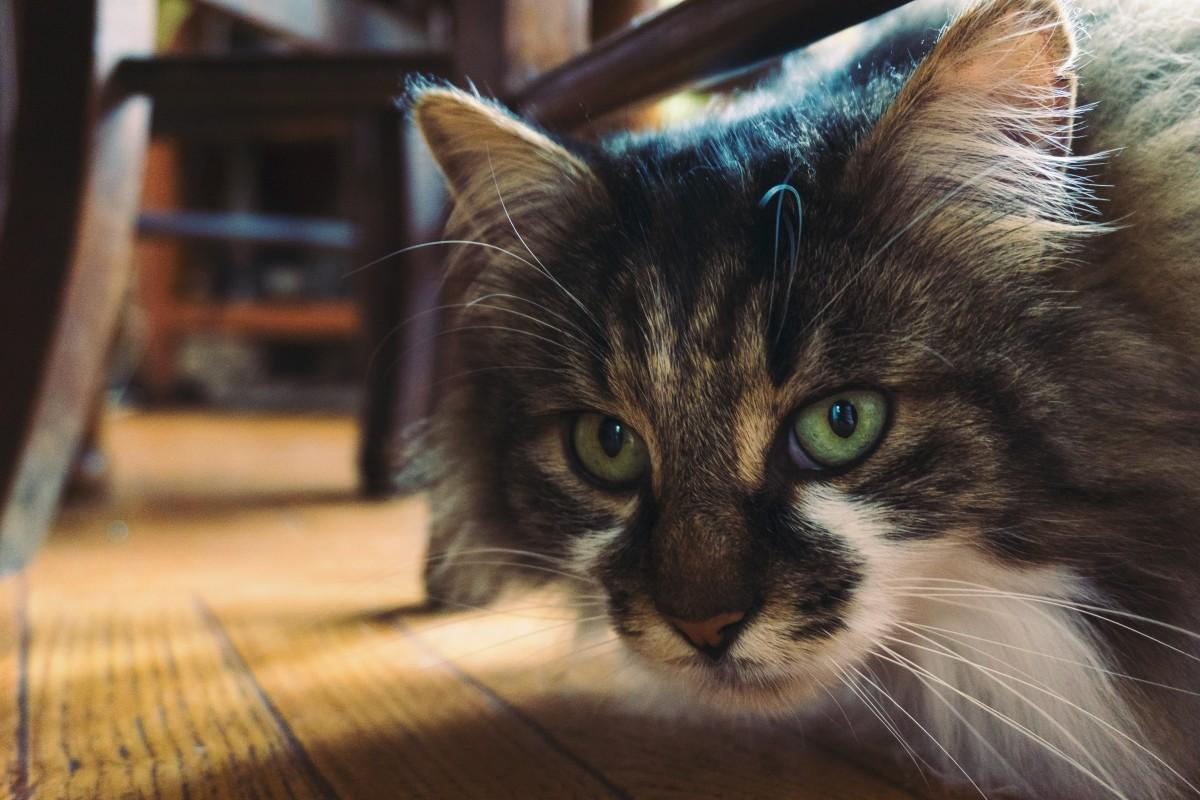

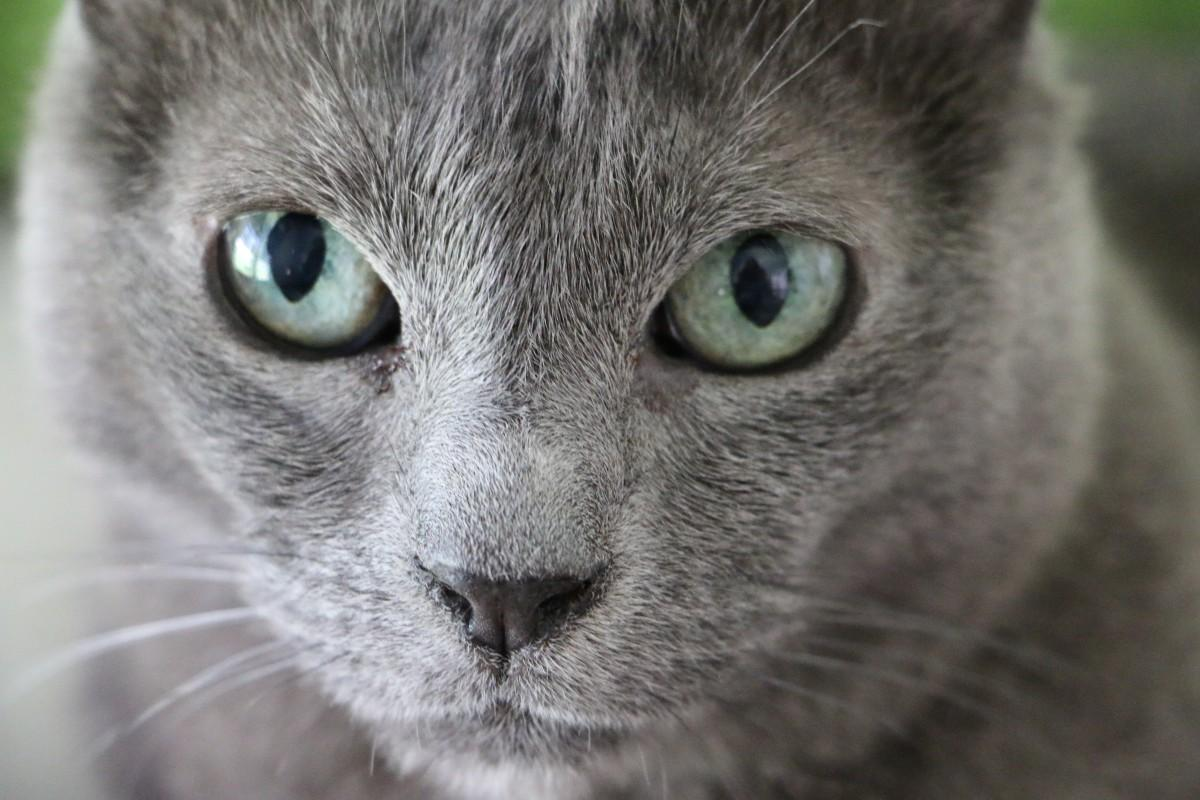

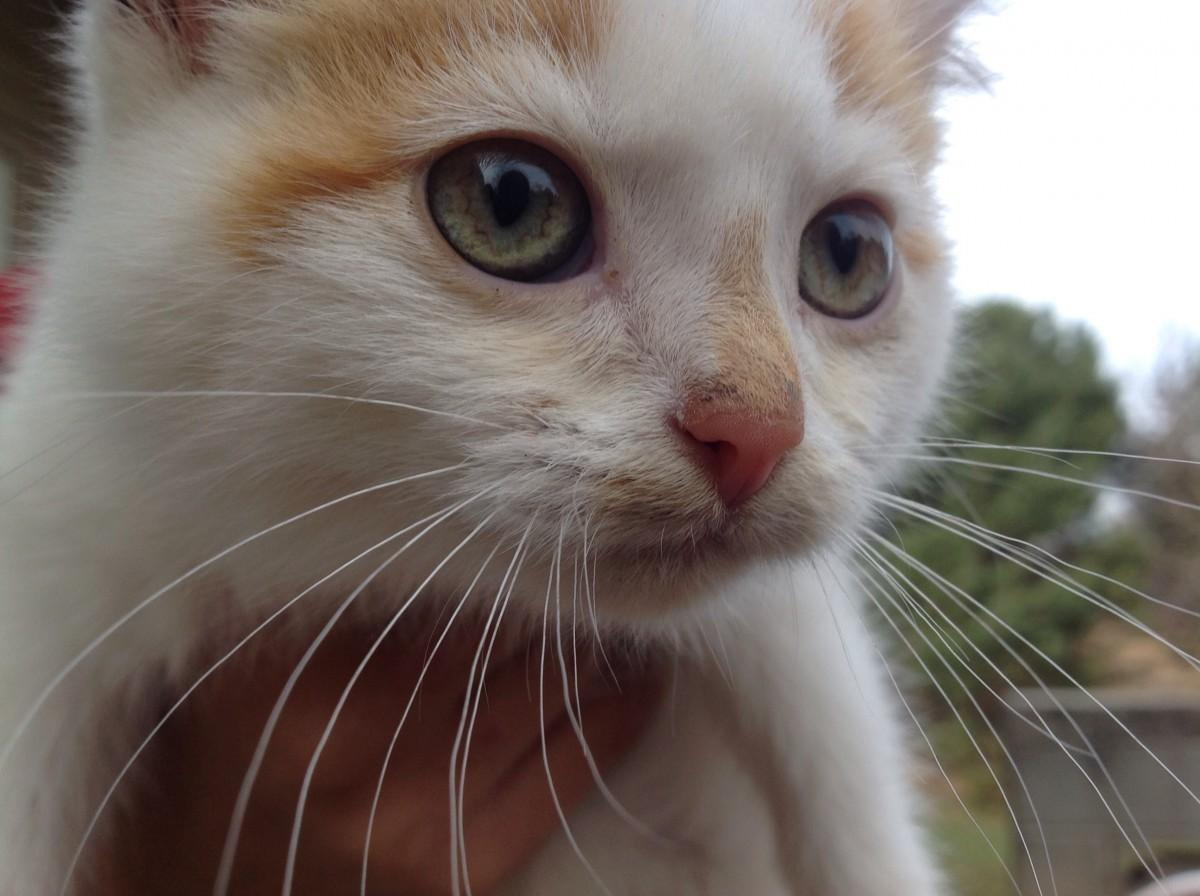

In [13]:
def display_images_with_input():
    query_text = input("Enter your search query --> ")
    max_distance = input("Enter the maximum distance (leave blank for no filter): ")
    max_distance = float(max_distance) if max_distance.strip() else None
    debug = input("Enable debug mode? (yes/no): ").strip().lower() == "yes"

    results = image_collection.query(
        query_texts=[query_text],
        n_results=5,
        include=['uris', 'distances']
    )

    uris = results['uris'][0]
    distances = results['distances'][0]

    for uri, distance in zip(uris, distances):
        if max_distance is None or distance <= max_distance:
            if debug:
                print(f"URI: {uri} - Distance: {distance}")
            display(Image(uri, width=300))
        else:
            if debug:
                print(f"URI: {uri} - Distance: {distance} (Filtered out)")

display_images_with_input()